# 1. Import libraries

In [1]:
# Data processing  
# -----------------------------------------------------------------------  
import pandas as pd  
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------  
pd.options.display.max_colwidth = None
 
# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore")

# Custom functions
# -----------------------------------------------------------------------
from src.eda_support import * # Revisar qué funciones necesito de aquí
from src.circuit_clustering_model.extract import *

In [2]:
import fastf1

# Config less verbosity
fastf1.set_log_level('ERROR')

# 2. Data loading

In [3]:
df_races = pd.read_csv('../data/output/races.csv')

df_races = df_races.loc[:, ['season', 'round', 'circuitId']]

In [4]:
df_races.head()

,season,round,circuitId
0,2010,1,bahrain
1,2010,2,albert_park
2,2010,3,sepang
3,2010,4,shanghai
4,2010,5,catalunya


El primer año del que podemos extraer telemetría es 2018 (ver fastf1 docs) por lo que lo haremos desde esta temporada

In [5]:
df_races = df_races[df_races['season'] >= 2018]

Vamos a almacenar la entrada más reciente de cada circuito. Luego si alguno nos da problemas volvemos a la siguiente entrada más reciente.

In [6]:
df_unique_circuits = df_races.drop_duplicates(subset=['circuitId'], keep='last')

In [7]:
df_unique_circuits.shape

(31, 3)

Tenemos un total de 31 circuitos para clusterizar

In [8]:
df_unique_circuits.head()

,season,round,circuitId
187,2019,11,hockenheimring
206,2020,9,mugello
208,2020,11,nurburgring
217,2021,3,portimao
229,2021,15,sochi


Procedemos a la extracción. Si ya tenemos los datos extraídos simplemente cargamos el dataset.

In [25]:
try:
    df = pd.read_csv('../data/output/circuits.csv', index_col=0)

except FileNotFoundError:
    print("Data not found: Extracting data...")
    df = extract_races_and_results_dataframes(df_races)
    df.to_csv('../data/output/circuits.csv')


El circuito de Mugello no tiene datos de las curvas. Sin embargo, como es un circuito en el que solamente se ha disputado un GP en 2020 de forma excepcional lo dejaremos a parte. De esta forma nos quedamos con 30 circuitos y con 22 columnas.

In [32]:
df.shape

(30, 22)

# 3. Data description

El conjunto de datos a analizar consiste en una tabla cuyas entradas son circuitos del campeonato del mundo de F1. Los circuitos se corresponden con las entradas que podemos encontrar en el dataframe `df_races`, cuyo detalle de extracción se puede encontrar en [poner fichero].

A partir de estos datos, la función `extract_races_and_results_dataframes()` se encarga de recuperar la información necesaria para caracterizar un circuito a partir de la vuelta más rápida de la clasificación (pole position).

Se ha utilizado la pole position porque normalmente es la vuelta más rápida del fin de semana y es menos sensible a estrategias de carrera como selección de neumáticos o cargas de combustible.

Para clusterizar adecuadamente los circuitos se han recopilado diferentes características clave de los mismos a partir de la telemetría de la vuelta. Los datos clave obtenidos (columnas del dataframe) son:

* `compound`: Compuesto con el que se ha llevado a cabo la vuelta de la pole position. 

* `laptime`: Tiempo total de la vuelta, en segundos.

* `max_speed`: Velocidad máxima alcanzada en la trampa de velocidad, en km/h.

* `distance`: Longitud total del circuito.

* `n_corners`: Número total de curvas del trazado.

* `avg_corner_speed`: Velocidad promedio de paso por curva, en km/h.

* `avg_speed`: Velocidad media de la vuelta, en km/h.

* `throttle_perc`: Porcentaje de acelerador a lo largo de la vuelta.

* `brake_perc`: Porcentaje de freno a lo largo de la vuelta.

* `straight_lenght`: Longitud total de las rectas (a partir de 500 m).

* `gear_changes`: Número total de cambios de marcha a lo largo de la vuelta.

* `n_slow_corners`: Número total de curvas lentas (velocidad < 120 kph)

* `n_medium_corners`: Número total de curvas lentas (velocidad < 240 kph)
       
* `n_fast_corners`: Número total de curvas lentas (velocidad > 240 kph)

* `n_gear{i}_corners`: Número total de curvas en cada marcha `i` (de 1 a 8)


Nota: la columna `compound` no la utilizaremos en el clustering sino que la utilizamos para filtrar vueltas en las que la sesión haya sido en mojado, lo que puede sesgar las condiciones del circuito. 

Muchas columnas posiblemente no las utilizaremos, haremos diferentes modelos con diferentes combinaciones de esta infromación.

Inicialmente no eliminaremos los duplicados, y conservaremos entradas del mismo circuito a lo largo de varias temporadas. Esto permitirá que podamos tener al menos una entrada en condiciones de seco para cada circuito, lo que es más representativo de las características del mismo.

In [28]:
df.columns

Index(['compound', 'laptime', 'max_speed', 'distance', 'n_corners',
       'avg_corner_speed', 'avg_speed', 'throttle_perc', 'brake_perc',
       'straight_lenght', 'gear_changes', 'n_slow_corners', 'n_medium_corners',
       'n_fast_corners', 'n_gear1_corners', 'n_gear2_corners',
       'n_gear3_corners', 'n_gear4_corners', 'n_gear5_corners',
       'n_gear6_corners', 'n_gear7_corners', 'n_gear8_corners'],
      dtype='object')

Podemos ver de qué temporadas tenemos circuitos

In [29]:
df_races['season'].unique()

array([2018, 2019, 2020, 2021, 2022, 2023, 2024])

Y cuántos circuitos diferentes tenemos en total

In [30]:
df_races['circuitId'].nunique()

31

Nota: deberíamos considerar eliminar las curvas que sean a fondo y/o agrupar las curvas o rectas por velocidad

Esto son next steps. Hacer si da tiempo

Más next steps: Añadir un campo que sea si es urbano o no y ver si hay diferencias significativas o cómo afecta a los clusters. Lo podríamos añadir a mano

# 4. Exploratory data analysis

En este caso, todas las columnas son numéricas.

In [33]:
df.head()

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,straight_lenght,...,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
hockenheimring,SOFT,71.767,320.0,4568.748333,17,209.960540,229.888136,78.359322,12.881356,1663.919441,...,9,5,0,1,3,1,3,5,3,1
nurburgring,SOFT,85.269,318.0,5112.340000,15,173.563856,216.201705,72.281250,17.329545,2043.790918,...,7,3,0,0,4,3,3,1,2,1
portimao,MEDIUM,77.968,314.0,4637.664722,15,188.740533,214.136223,73.058824,17.647059,1800.793691,...,5,6,0,0,4,2,1,4,4,0
sochi,SOFT,101.993,291.0,5789.306111,18,172.024977,204.520095,69.290780,17.494090,1284.998104,...,8,5,0,3,7,2,1,1,3,1
istanbul,SOFT,82.868,321.0,5253.130833,14,176.854350,228.286957,77.663768,15.072464,3877.396258,...,8,3,0,3,1,4,1,0,2,1


In [31]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
laptime,30.0,83.53,10.92,64.31,75.40,83.14,89.44,113.16
max_speed,30.0,317.90,18.16,270.00,308.75,321.50,328.25,347.00
distance,30.0,5135.74,773.08,3238.42,4584.94,5234.80,5744.24,6953.41
n_corners,30.0,16.50,3.19,10.00,14.25,16.00,18.75,27.00
avg_corner_speed,30.0,187.22,23.81,142.33,172.41,187.35,205.37,238.63
avg_speed,30.0,222.53,20.74,164.76,210.73,220.95,235.95,263.48
throttle_perc,30.0,72.74,6.66,55.01,69.30,73.32,77.28,83.73
brake_perc,30.0,16.35,3.68,11.44,13.77,15.85,18.12,27.14
straight_lenght,30.0,2360.69,1117.86,0.00,1441.63,2244.03,3254.38,4762.37
gear_changes,30.0,42.97,8.29,30.00,37.00,41.00,46.00,64.00


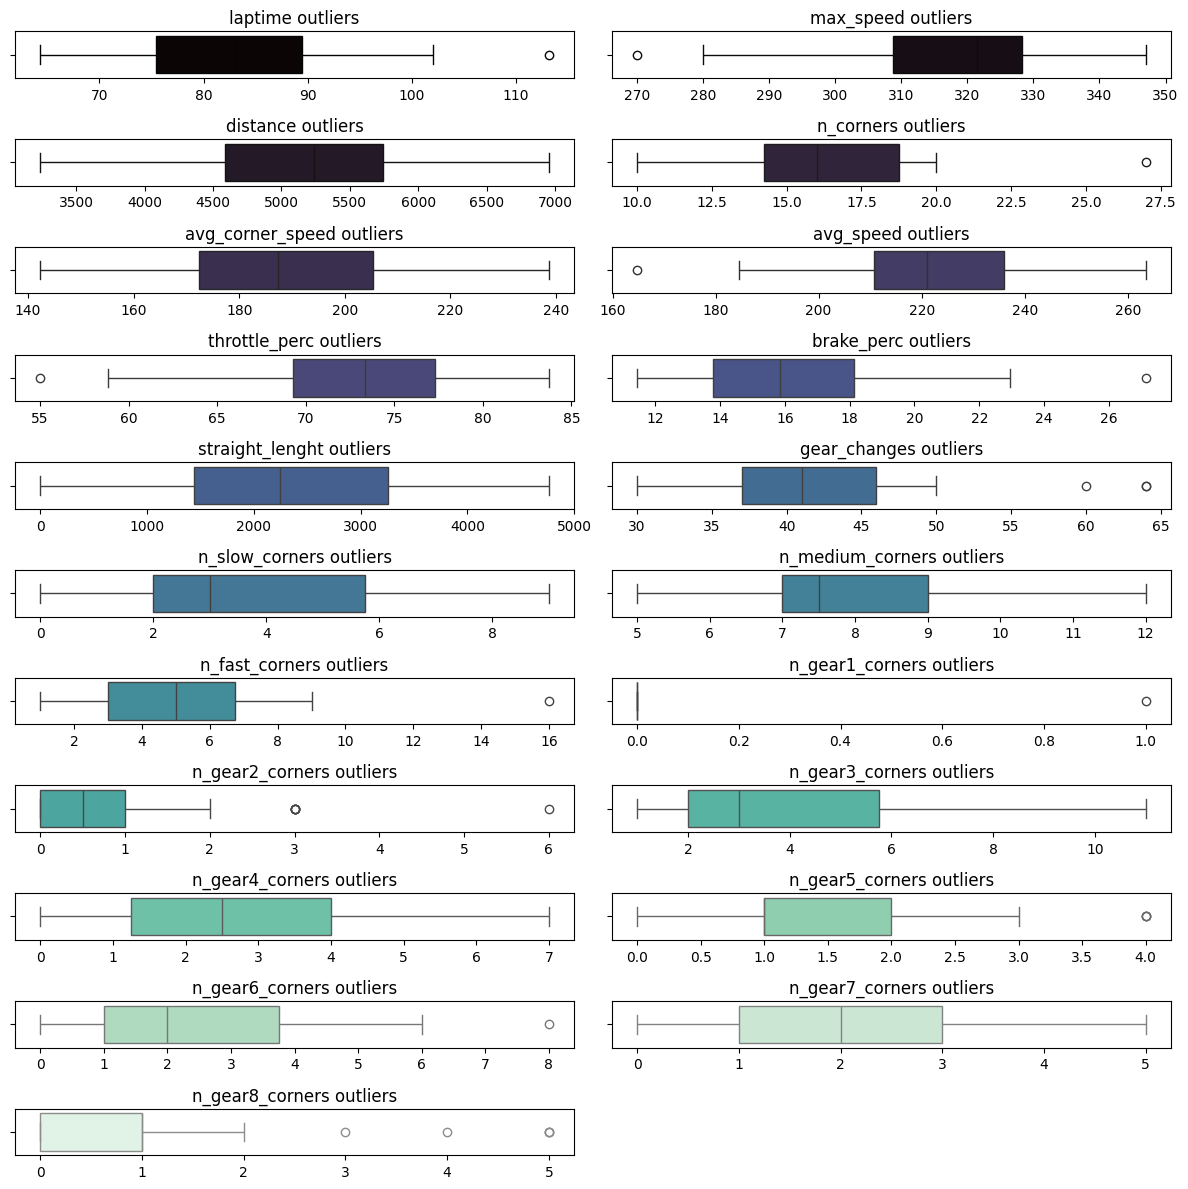

In [34]:
plot_outliers(df, size = (12, 12))

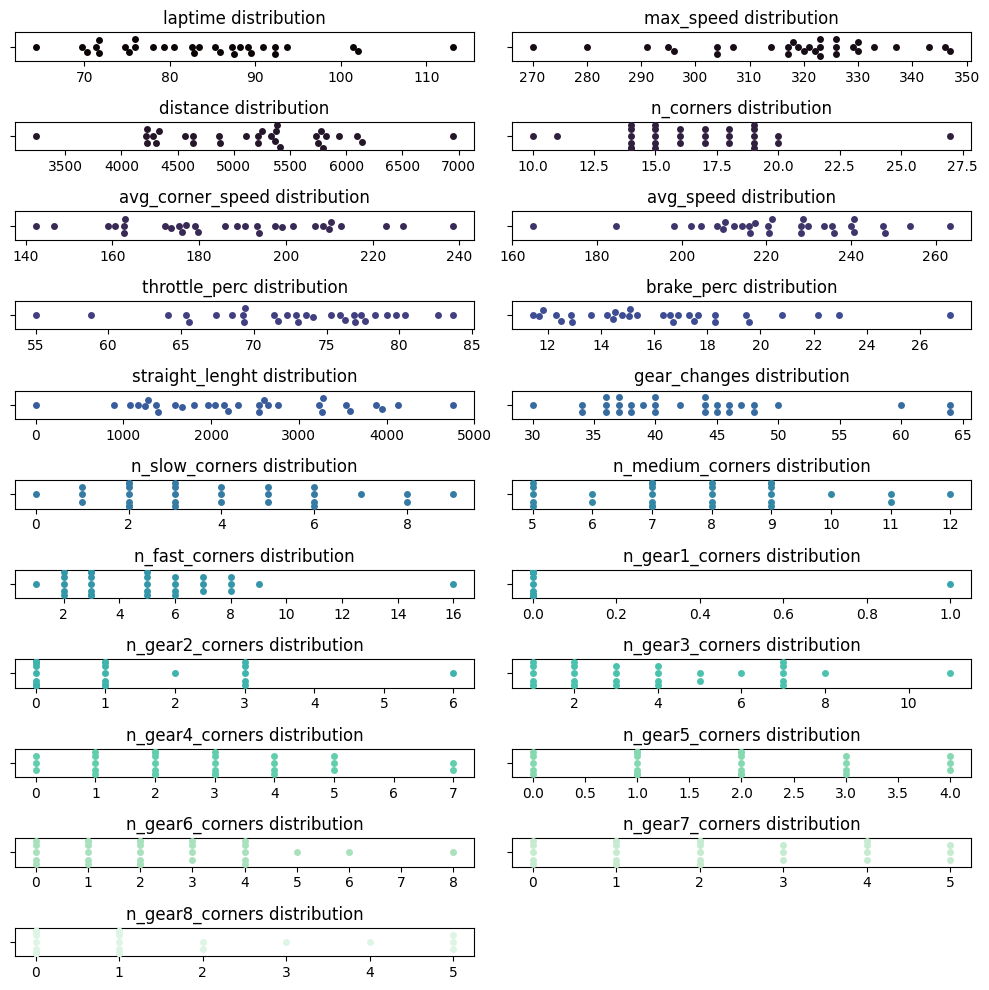

In [23]:
df_num = df.select_dtypes(include = np.number)
cols_num = df_num.columns

n_plots = len(cols_num)
num_rows = math.ceil(n_plots/2)

cmap = plt.cm.get_cmap('mako', n_plots)
color_list = [cmap(i) for i in range(cmap.N)]

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10,10))
axes = axes.flat

for i, col in enumerate(cols_num):

    sns.swarmplot(x = col, 
                data = df_num,
                ax = axes[i],
                color=color_list[i]) 
    
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel('')

# Remove last plot, if empty
if n_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

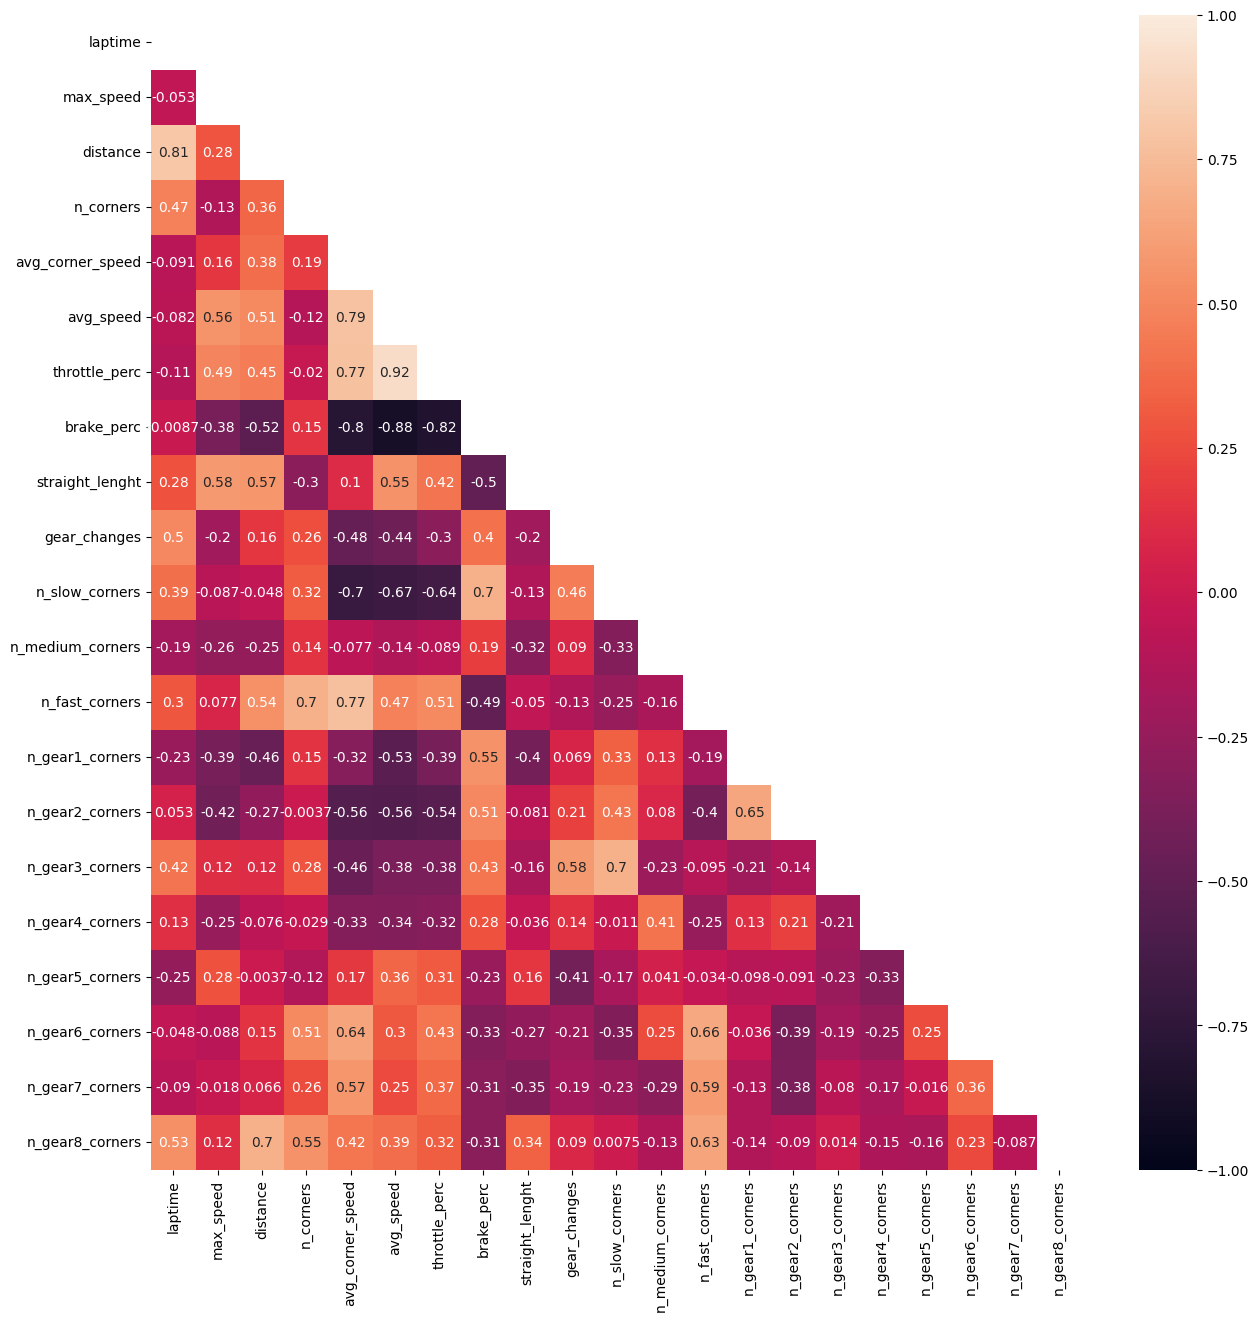

In [35]:
plot_correlation_matrix(df, size = (15, 15))

Explicar todo esto bien cuando me quede con el versión final

---

Next steps

* Eliminar curvas que sean a fondo

* Incluir rectas

* Contar número de curvas en función de la velocidad

* Número de frenadas